## Task

Detect stamps and signs on image, plot and save bounding boxes

## Solution

1. Preprocess image:
    - resize
    - binarize (RGB-image -> greyscale -> otsu threshold -> BW-image)
    - blur
2. Find clusters
3. For each cluster:
    - detect edges (cv2.Canny)
    - close figures (dilate+morph.closing)
    - find contours
4. Select largest contours

In [113]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import cv2
import glob
import json
import os

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

(800, 584, 3)


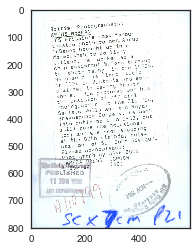

In [114]:
fname = 'sample1/1251229b.jpg' # 'sample1/1260637b.jpg' # 'sample1/1019060b.jpg' # 'process.png' # 
image = cv2.imread(fname)
if max(image.shape[:2]) > 800:
    scale = 800 / max(image.shape[:2]) 
    image = cv2.resize(image, dsize=None, fx=scale, fy=scale, interpolation=cv2.INTER_NEAREST)
print(image.shape)
plt.imshow(image)
#plt.imsave('ttt.png', image)

# RoI

Gray (800, 584)


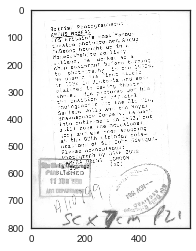

Thresh 200.0


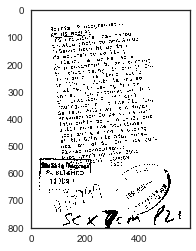

Edged


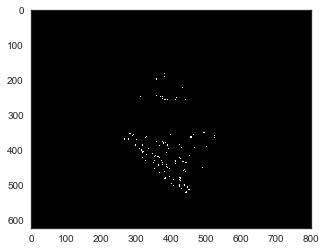

Dilated


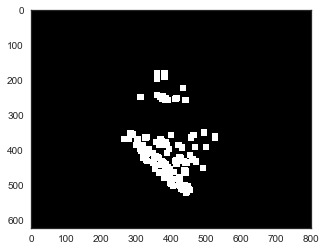

Closed


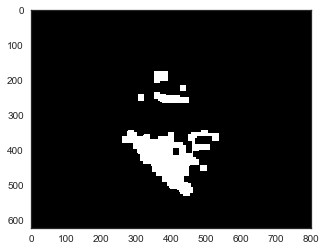

45

In [115]:
#grayscale
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
print('Gray', gray.shape)
plt.imshow(gray, cmap='gray')
plt.show()
 
#split image into background and object using Otsu’s Binarization
threshold_value,thresh = cv2.threshold(gray,200,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
if threshold_value < 200:
    threshold_value,thresh = cv2.threshold(gray,200,255,cv2.THRESH_BINARY)
print('Thresh', threshold_value)
plt.imshow(thresh, cmap='gray')
plt.show()

def make_border(imm, border = 10):
    imm[:border, :] = 0
    imm[-border:, :] = 0
    imm[:, :border:] = 0
    imm[:, -border:] = 0

ctrs = []
sel_i = 3
for i, cluster in enumerate(clusters):
    edged = cv2.Canny(cluster, 10, 250)
    make_border(edged)
    if i == sel_i:
        print('Edged',)
        plt.imshow(edged, cmap='gray')
        plt.show()
     
    kernel_size = max(image.shape) // 50
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
     
    dilation = cv2.dilate(edged, kernel, iterations=1)
    make_border(dilation)
    if i == sel_i:
        print('Dilated')
        plt.imshow(dilation, cmap='gray')
        plt.show()
    
    closing = cv2.morphologyEx(dilation, cv2.MORPH_CLOSE, kernel)
    make_border(closing)
    if i == sel_i:
        print('Closed')
        plt.imshow(closing, cmap='gray')
        plt.show()
     
    (image_cntr, ctrs_i, hiers) = cv2.findContours(closing, cv2.RETR_TREE, cv2.CHAIN_APPROX_TC89_KCOS)
    ctrs.extend(ctrs_i)
len(ctrs)

255 0


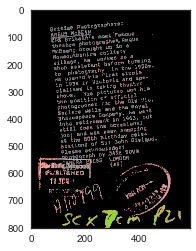

In [116]:
def blur_image(image, thresh):
    inv_thresh = np.tile((thresh == 0), reps=(3,1,1)).T.astype(np.uint8)
    inv_thresh = np.swapaxes(inv_thresh, 0, 1)
    im_copy = cv2.cvtColor(image, cv2.COLOR_RGB2LAB) # image.copy()
    im_copy[inv_thresh == 0] = 0
    blurred_image = cv2.blur(im_copy, (3,3)) # cv2.medianBlur(im_copy, 3)    #   #.GaussianBlur(im_copy, (3, 3), 0, 0)         
    blurred_mask = cv2.blur(inv_thresh, (3,3)) # cv2.medianBlur(inv_thresh, 3)    #   #.GaussianBlur(inv_thresh, (3, 3), 0, 0)     
    result = blurred_image / (blurred_mask + 1) 
    result = (result / result.max() * 255).astype(np.uint8)
    return result
result = blur_image(image, thresh)
print(result.max(), result.min())
plt.imshow(result)

7
6817


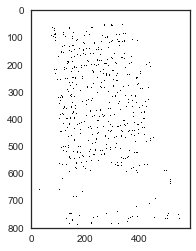

3664


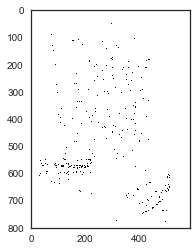

4336


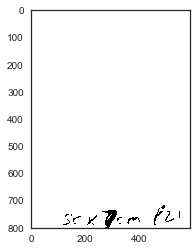

3420


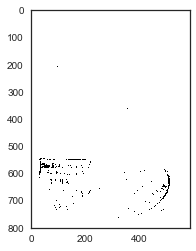

8794


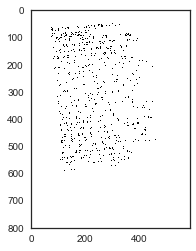

5065


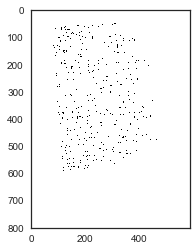

6301


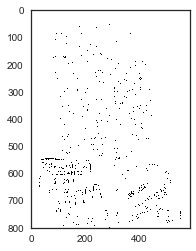

In [117]:
def cluster_image(image, thresh, n_clusters=7):
    pixel_colors = image[thresh == 0, ...] / 255
    pixel_locs = (np.argwhere(thresh == 0) / thresh.shape[:2]) - 0.5
    pixels = np.hstack((pixel_colors, pixel_locs / 200)) # color is 2 times more important than location
    pixels = pixels.reshape(-1, pixels.shape[-1])
    clt =  KMeans(n_clusters = n_clusters, n_jobs=-1) # AgglomerativeClustering(n_clusters=n_clusters) #   DBSCAN(n_jobs=-1) # 
    clt.fit(pixels)
    result = []
    for lab in np.unique(clt.labels_):
        clust = np.ones(shape=image.shape[:2]) * 255
        clust[thresh == 0] = (clt.labels_ != lab) * 255
        result.append(clust.astype(np.uint8))
    return result
#clusters = cluster_image(cv2.cvtColor(image, cv2.COLOR_RGB2LAB), thresh, n_clusters=7)
clusters = cluster_image(result , thresh, n_clusters=7)
print(len(clusters))
for c in clusters:
    print((c==0).sum())
    plt.imshow(c, cmap='gray')
    plt.show()

In [118]:
def make_border(imm, border = 10):
    imm[:border, :] = 0
    imm[-border:, :] = 0
    imm[:, :border:] = 0
    imm[:, -border:] = 0
    
def get_contours(image):
    #grayscale
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    
    #split image into background and object using Otsu’s Binarization
    threshold_value,thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    threshold_value,thresh = cv2.threshold(gray,200,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    if threshold_value < 200:
        threshold_value,thresh = cv2.threshold(gray,200,255,cv2.THRESH_BINARY) 
    
    #blur masked image
    blurred = blur_image(image, thresh)
    
    #cluster image by color and location
    clusters = cluster_image(blurred, thresh, n_clusters=7)
    ctrs = []
    for cluster in clusters:
        # detect edges
        edged = cv2.Canny(cluster, 10, 250)
        make_border(edged)
         
        # dilate = make objects thicker
        kernel_size = max(image.shape) // 50
        kernel = np.ones((kernel_size, kernel_size), np.uint8)
        dilation = cv2.dilate(edged, kernel, iterations=1)
        make_border(dilation)
        
        # close objects
        closing = cv2.morphologyEx(dilation, cv2.MORPH_CLOSE, kernel)
        make_border(closing)
         
        (image_cntr, ctrs_clust, hiers) = cv2.findContours(closing, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        ctrs.append(ctrs_clust)
    return ctrs
ctrs = get_contours(image)
print(len(ctrs), sum(len(l) for l in ctrs))

7 80


In [121]:
def is_1_inside_2(ctr1, ctr2, gap=20):
    x1, y1, w1, h1 = cv2.boundingRect(ctr1)
    x2, y2, w2, h2 = cv2.boundingRect(ctr2)
    inside_x = (x1 + gap >= x2) and (x1 + w1 <= x2 + w2 + gap)
    inside_y = (y1 + gap >= y2) and (y1 + h1 <= y2 + h2 + gap)  
    return inside_x and inside_y

def get_square(ctr):
    h, w = cv2.boundingRect(ctr)[2:4]
    return h * w

def filter_contours_by_square(contours, image, min_pct=0.0005, max_pct=0.9):
    image_square = image.shape[0] * image.shape[1] 
    min_square = image_square * min_pct
    max_square = image_square * max_pct
    return [[ctr for ctr in ctrs_list if  max_square >= get_square(ctr) >= min_square] 
            for ctrs_list in contours]

def get_top_contours(contours):
    result = []
    for ctrs_list in contours:
        top_ctrs = []
        for ctr in sorted(ctrs_list, key=get_square, reverse=True):  # from largest to smallest
            is_inside_top = False
            for top_ctr in top_ctrs:
                if is_1_inside_2(ctr, top_ctr):
                    is_inside_top = True
                    break
            if not is_inside_top:
                top_ctrs.append(ctr)
        result.extend(top_ctrs)
    return result

def filter_by_inclusion(contours):
    top_ctrs = []
    for ctr in sorted(contours, key=get_square, reverse=True):  # from largest to smallest
        wrong_inclusion = False
        for top_ctr in top_ctrs:
            if (is_1_inside_2(ctr, top_ctr) 
                and ((get_square(ctr) < 0.05 * get_square(top_ctr))
                     or (0.6 * get_square(top_ctr) < get_square(ctr)))):
                wrong_inclusion = True
                break
        if not wrong_inclusion:
            top_ctrs.append(ctr)
    return top_ctrs

filtered_ctrs = filter_contours_by_square(ctrs, image, min_pct=0.001, max_pct=0.8)
print(len(filtered_ctrs))

top_ctrs = get_top_contours(filtered_ctrs)
print(len(top_ctrs))

top_ctrs = filter_by_inclusion(top_ctrs)
print(len(top_ctrs))

7
32
10


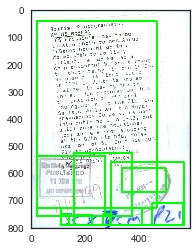

In [122]:
def plot_ctrs(image, contours, **args):
    result = image.copy()
    for i, ctr in enumerate(top_ctrs):
        x, y, w, h = cv2.boundingRect(ctr)
        roi = result[y:y+h, x:x+w]
        cv2.rectangle(result,(x,y),( x + w, y + h ), **args)
    return result

result = plot_ctrs(image, top_ctrs, color=(0,255,0), thickness=5)
plt.imshow(result)
#plt.imsave('result_cluster_blur2.png', result)

# Test

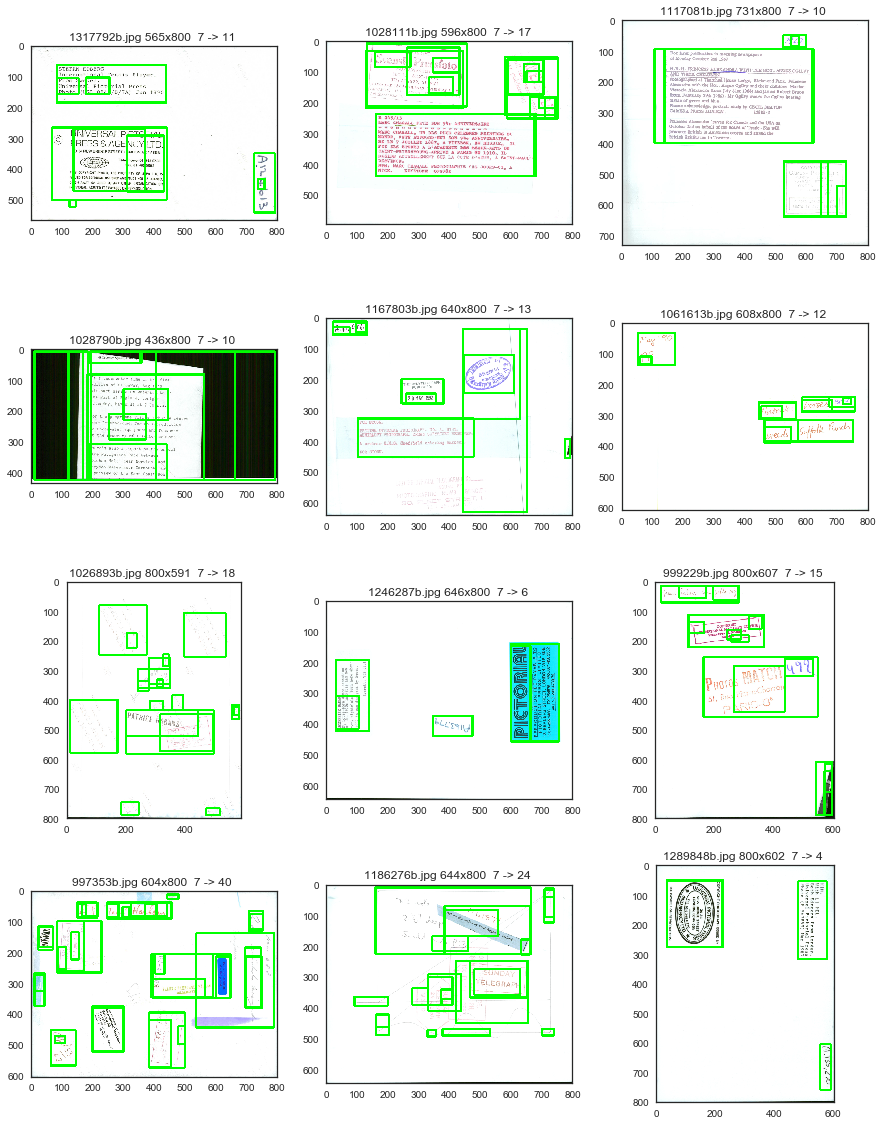

In [109]:
cols, rows = 3, 4
st = 76
ssize = 5
_, axes = plt.subplots(rows, cols, figsize=(cols * ssize, rows * ssize))
fnames = glob.glob('sample1/*jpg')[st:st + cols * rows]
for fname, ax in zip(fnames, axes.flatten()):
    image = cv2.imread(fname)
    if max(image.shape[:2]) > 800:
        scale = 800 / max(image.shape[:2]) 
        image = cv2.resize(image, dsize=None, fx=scale, fy=scale, interpolation=cv2.INTER_NEAREST)

    ctrs = get_contours(image)
    filtered_ctrs = filter_contours_by_square(ctrs, image, min_pct=0.001, max_pct=0.7)
    top_ctrs = get_top_contours(filtered_ctrs)
    top_ctrs = filter_by_inclusion(top_ctrs)
    shape_str = ' %dx%d ' % image.shape[:2]
    ctrs_str = ' %d -> %d ' % (len(ctrs), len(top_ctrs))
    ax.set_title(os.path.split(fname)[-1] + shape_str + ctrs_str)
    result = plot_ctrs(image, top_ctrs, color=(0,255,0), thickness=5)
    ax.imshow(result)

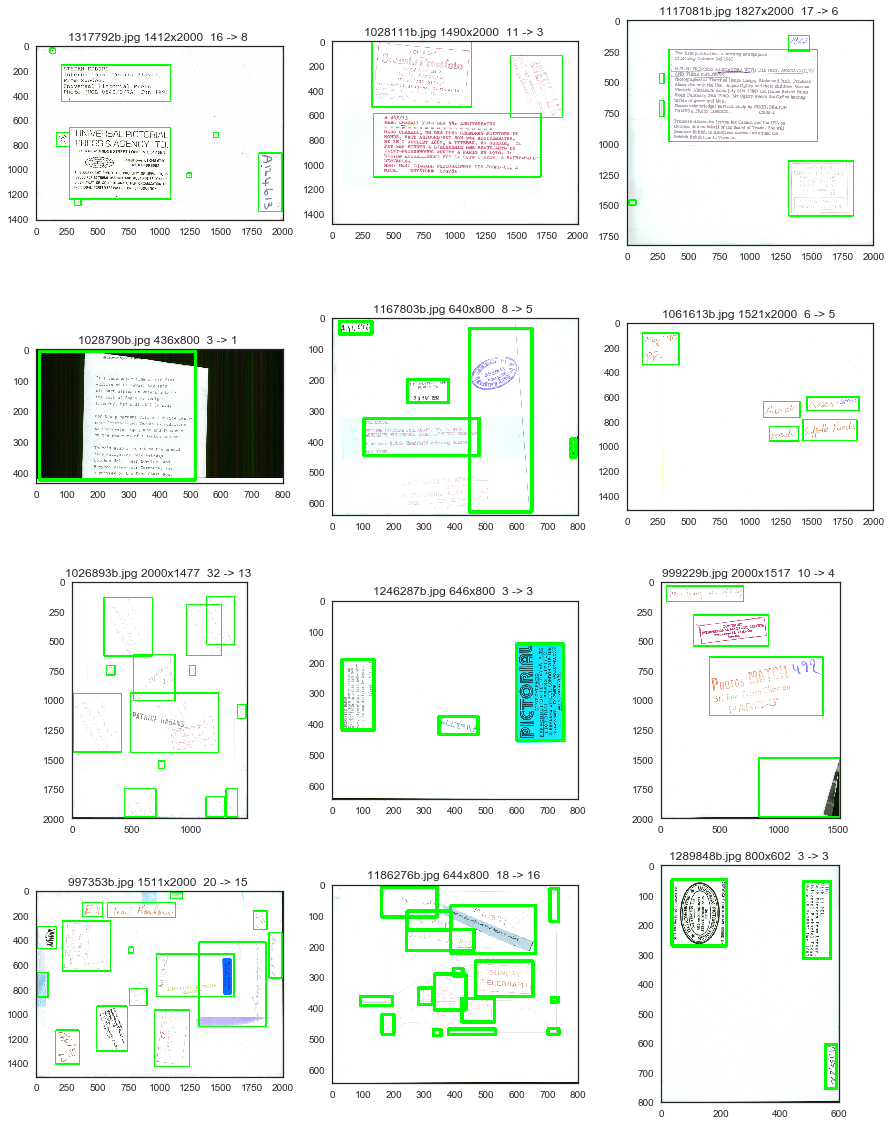

In [171]:
cols, rows = 3, 4
st = 76
ssize = 5
_, axes = plt.subplots(rows, cols, figsize=(cols * ssize, rows * ssize))
fnames = glob.glob('sample1/*jpg')[st:st + cols * rows]
for fname, ax in zip(fnames, axes.flatten()):
    image = cv2.imread(fname)
    ctrs = get_contours(image)
    filtered_ctrs = filter_contours_by_square(ctrs, image, min_pct=0.0005, max_pct=0.7)
    top_ctrs = get_top_contours(filtered_ctrs)
    shape_str = ' %dx%d ' % image.shape[:2]
    ctrs_str = ' %d -> %d ' % (len(ctrs), len(top_ctrs))
    ax.set_title(os.path.split(fname)[-1] + shape_str + ctrs_str)
    result = plot_ctrs(image, top_ctrs, color=(0,255,0), thickness=10)
    ax.imshow(result)

In [124]:
def save_ctrs(source_image, contours, scale, result_dir):
    for i, ctr in enumerate(contours):
        x, y, w, h = [int(v / scale) for v in cv2.boundingRect(ctr)]
        roi = source_image[y:y+h, x:x+w]
        fname = os.path.join(result_dir, 'region_%02d.jpg' % i)
        cv2.imwrite(fname, roi)
        fname = os.path.join(result_dir, 'region_%02d.json' % i)
        obj = {'x': x, 'y': y, 'w': w, 'h': h}
        with open(fname, 'wt') as f:
            json.dump(obj, f)
save_ctrs(plt.imread('sample1/1251229b.jpg'), top_ctrs, scale, 'out_dir')

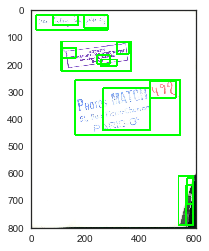

In [132]:
!python processphoto.py -i sample1/999229b.jpg -o result_v2_sample1/999229b.jpg -d result_v2_sample1/999229b
plt.imshow(plt.imread('out.png'))